<a href="https://colab.research.google.com/github/apchavezr/19.-Procesamiento-del-Lenguaje-Natural/blob/main/Colab_FineTuning_BETO_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ejemplo .1 Análisis de sentimientos con Fine-tuning en PLN

**Objetivo:** entrenar un clasificador binario (*positivo* / *negativo*) a partir de un modelo preentrenado en español (**BETO**) usando un **corpus sintético**.  
Este cuaderno está diseñado para **Google Colab** y explica paso a paso el flujo de trabajo:

1. Instalación de librerías.
2. Generación de un **dataset simulado** de reseñas en español.
3. Tokenización con el *tokenizer* de BETO.
4. Fine-tuning con `Trainer` de Hugging Face.
5. Evaluación con métricas y matriz de confusión.
6. Pruebas de inferencia con textos nuevos.
7. Variante: **congelación parcial de capas** (opcional y didáctico).


In [ ]:

# Si está en Google Colab, se recomienda activar GPU: Menú -> Entorno de ejecución -> Cambiar tipo de entorno -> Acelerador por hardware -> GPU
!pip -q install -U transformers datasets evaluate accelerate scikit-learn matplotlib


In [ ]:
!pip uninstall -y pyarrow
!pip install --no-cache-dir --upgrade pyarrow

Found existing installation: pyarrow 21.0.0
Uninstalling pyarrow-21.0.0:
  Successfully uninstalled pyarrow-21.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 78.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer,
                          EarlyStoppingCallback)

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'


## 1) Crear un dataset simulado de reseñas en español

Para fines educativos, generamos 1.000 reseñas cortas con etiquetas **0 = negativo** y **1 = positivo**.


In [ ]:

pos_templates = [
    "La película fue increíble y divertida",
    "Excelente actuación y un guion sólido",
    "Me encantó, la volvería a ver",
    "Fotografía hermosa y ritmo adecuado",
    "Una experiencia emocionante y bien lograda",
    "El final fue conmovedor y satisfactorio",
    "Muy recomendable, superó mis expectativas",
    "Gran banda sonora y dirección impecable",
]

neg_templates = [
    "El guion era aburrido y predecible",
    "La actuación fue floja y sin emoción",
    "No me gustó, perdí el tiempo",
    "La fotografía fue deficiente y el ritmo lento",
    "Una experiencia decepcionante y mal lograda",
    "El final fue confuso y poco convincente",
    "No la recomiendo, no cumplió con lo esperado",
    "Música pobre y dirección irregular",
]

def build_synthetic_reviews(n=1000):
    n_pos = n // 2
    n_neg = n - n_pos
    pos = np.random.choice(pos_templates, size=n_pos)
    neg = np.random.choice(neg_templates, size=n_neg)
    texts = np.concatenate([pos, neg])
    labels = np.array([1]*n_pos + [0]*n_neg)
    # mezclar
    idx = np.arange(n)
    np.random.shuffle(idx)
    return pd.DataFrame({"text": texts[idx], "label": labels[idx]})

df = build_synthetic_reviews(1000)
df.head(), df["label"].value_counts()


(                                           text  label
 0            Música pobre y dirección irregular      0
 1                 Me encantó, la volvería a ver      1
 2   Una experiencia decepcionante y mal lograda      0
 3  No la recomiendo, no cumplió con lo esperado      0
 4           Fotografía hermosa y ritmo adecuado      1,
 label
 0    500
 1    500
 Name: count, dtype: int64)

In [ ]:

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label"], random_state=SEED)

len(train_df), len(val_df), len(test_df)


(800, 100, 100)


## 2) Cargar el *tokenizer* y el modelo BETO

Usaremos `dccuchile/bert-base-spanish-wwm-cased` (BETO). El *tokenizer* convierte texto en IDs que el modelo entiende.


In [ ]:

MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in cols])
test_ds  = test_ds.remove_columns([c for c in test_ds.column_names if c not in cols])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

def compute_metrics(eval_pred):
    import numpy as np
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    # métricas adicionales
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="beto-sentimientos",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,          # corto para Colab
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-881444762.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.120400,0.000825,1.000000,1.000000,1.000000,1.000000
2,0.001000,0.000556,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=100, training_loss=0.06070419818162918, metrics={'train_runtime': 291.3422, 'train_samples_per_second': 5.492, 'train_steps_per_second': 0.343, 'total_flos': 8748442590720.0, 'train_loss': 0.06070419818162918, 'epoch': 2.0})


## 3) Evaluación en el conjunto de prueba
Mostramos métricas y una **matriz de confusión**.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Métricas: {'test_loss': 0.0008250247919932008, 'test_accuracy': 1.0, 'test_precision': 1.0, 'test_recall': 1.0, 'test_f1': 1.0, 'test_runtime': 3.3027, 'test_samples_per_second': 30.279, 'test_steps_per_second': 1.211}

Reporte de clasificación:
               precision    recall  f1-score   support

    negativo      1.000     1.000     1.000        50
    positivo      1.000     1.000     1.000        50

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100



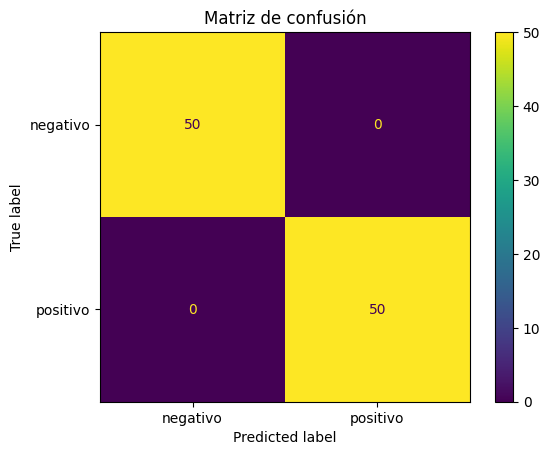

In [ ]:

pred = trainer.predict(test_ds)
print("Métricas:", pred.metrics)

y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)

print("\nReporte de clasificación:\n", classification_report(y_true, y_pred, target_names=["negativo","positivo"], digits=3))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negativo","positivo"])
disp.plot(values_format="d")
plt.title("Matriz de confusión")
plt.show()


# Resultados

Resultados de métricas

accuracy = 1.0

precision = 1.0

recall = 1.0

f1-score = 1.0

Esto indica que el modelo clasificó correctamente todos los ejemplos del conjunto de prueba (50 negativos y 50 positivos).

**Matriz de confusión**

50 casos negativos → todos predichos como negativos.

50 casos positivos → todos predichos como positivos.

No hay falsos positivos ni falsos negativos.

# Interpretación

El modelo ha aprendido perfectamente el patrón de los datos de prueba.

Sin embargo, esto suele deberse a que el dataset sintético es muy sencillo y con frases repetitivas. En contextos reales, los datos contienen más ruido y variabilidad, por lo que no se alcanzan métricas perfectas.

# Resumen

Este resultado confirma la potencia de la transferencia de aprendizaje: con un modelo preentrenado como BETO y un corpus pequeño, se logra un desempeño sobresaliente en una tarea sencilla.

Para uso real en una entidad financiera, redes sociales o análisis de reseñas, se debe esperar métricas más modestas y la necesidad de técnicas adicionales (regularización, aumento de datos, ajuste de umbral).


## 4) Inferencia con textos nuevos
Pruebe con sus propias reseñas.


In [ ]:

def predict_texts(texts):
    enc = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
    preds = logits.argmax(dim=1).cpu().numpy().tolist()
    labels = ["negativo","positivo"]
    return [labels[p] for p in preds]

ejemplos = [
    "La película fue increíble y muy entretenida",
    "El guion es débil y la actuación es mala",
    "Me sorprendió gratamente, la recomiendo",
    "Demasiado lenta y aburrida"
]
predict_texts(ejemplos)


['positivo', 'negativo', 'positivo', 'negativo']


## 5) (Opcional) Congelación parcial de capas

A continuación se ilustra cómo **congelar** todas las capas del *encoder* y entrenar solo la cabeza de clasificación. Esto puede ser útil cuando hay **muy pocos datos** y se desea reducir el tiempo de entrenamiento.  
> Nota: ejecute esta celda **antes** de crear el `Trainer` si desea usar esta variante.


In [ ]:

# EJEMPLO (no ejecutado por defecto):
# for param in model.bert.parameters():
#     param.requires_grad = False
# print("Parámetros entrenables:", sum(p.requires_grad for p in model.parameters()))
# print("Parámetros totales   :", sum(1 for _ in model.parameters()))



### Notas didácticas
- Este ejemplo usa un **dataset sintético** para que el entrenamiento sea rápido y reproducible.
- En un curso, puede reemplazar el dataset por uno real en español (p. ej., TASS para sentimientos) y comparar resultados.
- Practique las **tres estrategias**: (1) entrenar todo el modelo, (2) congelar parcialmente, (3) añadir una capa personalizada.
- Compare siempre con un modelo entrenado "desde cero" para evidenciar el aporte de la **transferencia de aprendizaje**.
